<a href="https://colab.research.google.com/github/henriquevedoveli/TCC/blob/main/notebooks/models/tccVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import *
 
import tensorflow as tf
from tensorflow import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
 
# keras models
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping#

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image  
 
########################################################################################
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

np.random.seed(7)
 
import os
 
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN = '/content/drive/MyDrive/TCC/data/chest_xray/train'
TEST = '/content/drive/MyDrive/TCC/data/chest_xray/test'
VAL = '/content/drive/MyDrive/TCC/data/chest_xray/val'

MODELS = '/content/drive/MyDrive/TCC/MODELS'

In [ ]:
trainData = ImageDataGenerator(zoom_range = [0.9, 1.25], 
                                        rotation_range = 10,
                                        vertical_flip = True,
                                        horizontal_flip = False, 
                                        width_shift_range = 0.1, 
                                        height_shift_range = 0.1,
                                        # brightness_range = [0.5, 1],
                                        # shear_range = .7,
                                        fill_mode='constant', 
                                        cval=0)

trainData = trainData.flow_from_directory(directory=TRAIN,
                                       batch_size = 32,
                                       target_size=(224,224),
                                       color_mode = 'grayscale',
                                      )


valData = ImageDataGenerator()
valData = valData.flow_from_directory(
        VAL,
        target_size = (224,224),
        batch_size = 32,
        color_mode = 'grayscale'
        )


testData = ImageDataGenerator()
testData = testData.flow_from_directory(directory=TEST,
                                      batch_size = 32,
                                      target_size=(224,224),
                                      color_mode = 'grayscale')

Found 5082 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


# Pesando os dados

In [ ]:
normalLength = len(os.listdir(TRAIN + '/' + 'NORMAL'))
bacterialLength = len(os.listdir(TRAIN + '/' + 'BACTERIAL'))
viralLength = len(os.listdir(TRAIN + '/' + 'VIRAL'))
dataLength = normalLength + bacterialLength +  viralLength

print('Qtd dados de treino: ', dataLength)
print('Qtd dados de pulmão saudavel para treino: ', normalLength)
print('Qtd dados Bacterial', bacterialLength)
print('Qtd dados Viral', viralLength)

Qtd dados de treino:  5082
Qtd dados de pulmão saudavel para treino:  1299
Qtd dados Bacterial 2488
Qtd dados Viral 1295


In [ ]:
class_weight = {0: 1., # bacterial
                1: bacterialLength / normalLength, #normal 
                2: bacterialLength / viralLength} # viral 

print(class_weight)

{0: 1.0, 1: 1.9153194765204002, 2: 1.9212355212355212}


# Funções para a avaliação do modelo

In [ ]:
def generateImages(paths):
    '''
    params: paths ->
    '''
    test_images=[]
    interpret= trainData.class_indices
    test_y=[]
    
    for path in paths:
        y=''
        if 'NORMAL' in path:
            y='NORMAL'
        elif 'VIRAL' in path:   
            y='VIRAL'
        elif 'BACTERIAL' in path:   
            y='BACTERIAL'   
        
        for image_path in os.listdir(path):
            new_path=os.path.join(TEST, y)
            new_path=os.path.join(new_path,image_path)

            temp_images=image.load_img(new_path,
                                       color_mode = 'grayscale',
                                       target_size=(224,224)) 
            temp_images=image.img_to_array(temp_images)
            test_images.append(temp_images)
            test_y.append(interpret[y])

    return test_images,test_y

In [ ]:
def convertData(model, path, prob = 0):
    '''
    params: model ->
            path ->
            prob ->
    '''
    all_paths=[]
    print("• GERANDO PATHS")

    ##### REVISAR #######
    for directory in os.listdir(path):
        all_paths.append(os.path.join(path,directory))
    ##### REVISAR #######
    
    test_images, test_y= generateImages(all_paths)

    test_images=np.array(test_images)

    print("• GERANDO PREVISÕES")
    if prob == 0:
        predictions = np.argmax(model.predict(test_images), axis=1)
    else:
        predictions = model.predict_on_batch(test_images)

    ##### FAZER MODIFICACAO +75 AQ
    ##### SUBSTITUIR PREDICTIONS POR PRED75
    print("ACURACIA DO MODELO PARA OS DADOS DE TESTE: {}".format( metrics.accuracy_score(test_y, predictions)))

    return test_y, predictions, test_images

# VGG TRAINING

In [ ]:
modelVGG = tf.keras.applications.VGG16(input_shape=(224, 224, 1),include_top=False, weights=None)

## Valores encontrados com hypertuning
units = 840
lr = 0.0001
######################################

modelVGG = tf.keras.Sequential([
        modelVGG,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3,activation=tf.nn.softmax)
        ])


modelVGG.compile(loss='categorical_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=lr),
                     metrics = ['accuracy'])

In [ ]:
modelVGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 840)               21074760  
                                                                 
 dropout (Dropout)           (None, 840)               0         
                                                                 
 dense_1 (Dense)             (None, 840)               706440    
                                                                 
 dropout_1 (Dropout)         (None, 840)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 2

In [ ]:
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')

hist = modelVGG.fit_generator(steps_per_epoch= trainData.n//32,
                           generator=trainData, 
                           validation_data= valData,
                           validation_steps=valData.n//32,
                           epochs=20,
                           class_weight = class_weight)

Epoch 1/20
158/158 [==============================] - 127s 802ms/step - loss: 0.2840 - accuracy: 0.9119 - val_loss: 0.6244 - val_accuracy: 0.8125
Epoch 2/20
158/158 [==============================] - 127s 798ms/step - loss: 0.2761 - accuracy: 0.9117 - val_loss: 0.6677 - val_accuracy: 0.7734
Epoch 3/20
158/158 [==============================] - 127s 799ms/step - loss: 0.2536 - accuracy: 0.9212 - val_loss: 0.7471 - val_accuracy: 0.7891
Epoch 4/20
158/158 [==============================] - 127s 798ms/step - loss: 0.2643 - accuracy: 0.9143 - val_loss: 0.6714 - val_accuracy: 0.7891
Epoch 5/20
158/158 [==============================] - 127s 799ms/step - loss: 0.2369 - accuracy: 0.9242 - val_loss: 0.6780 - val_accuracy: 0.7891
Epoch 6/20
158/158 [==============================] - 127s 800ms/step - loss: 0.2467 - accuracy: 0.9230 - val_loss: 0.7639 - val_accuracy: 0.7656
Epoch 7/20
158/158 [==============================] - 127s 798ms/step - loss: 0.2377 - accuracy: 0.9273 - val_loss: 0.7165 -

In [ ]:
temp = pd.DataFrame([hist.history['accuracy'], hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss']])

histT = temp.T
histT.columns = ['acc', 'val_acc', 'loss', 'val_loss']

from google.colab import files
numEpoch = 20
histT.to_csv(f'histTreinoVGG{numEpoch}.csv')
files.download(f'histTreinoVGG{numEpoch}.csv')

histT

In [ ]:
temp = pd.DataFrame([hist.history['accuracy'], hist.history['val_accuracy'], hist.history['loss'], hist.history['val_loss']])

tempT = temp.T
tempT.columns = ['acc', 'val_acc', 'loss', 'val_loss']

histTreinoatg = pd.read_csv('histTreinoVGG80.csv')
histTreinoatg = histTreinoatg[['acc', 'val_acc', 'loss', 'val_loss']]
histT = histTreinoatg.append(tempT)
histT = histT.reset_index(drop=True)

from google.colab import files
numEpoch = 100
histT.to_csv(f'histTreinoVGG{numEpoch}.csv')
files.download(f'histTreinoVGG{numEpoch}.csv')

histT

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,acc,val_acc,loss,val_loss
0,0.374,0.531,1.597,0.907
1,0.558,0.672,1.350,0.777
2,0.606,0.766,1.131,0.586
3,0.641,0.695,1.033,0.596
4,0.690,0.766,0.933,0.486
...,...,...,...,...
95,0.934,0.836,0.209,0.574
96,0.936,0.797,0.206,0.650
97,0.942,0.797,0.192,0.767
98,0.946,0.852,0.180,0.716


In [ ]:
histT = pd.read_csv('histTreinoVGG100.csv')

[]

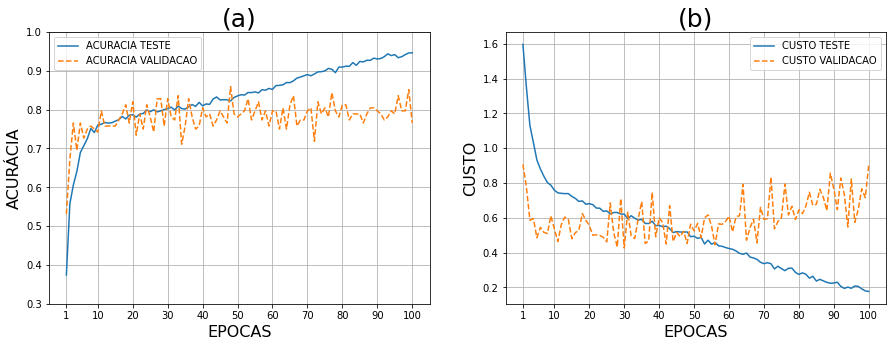

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

axs[0].plot(histT.index + 1, histT['acc'])
axs[0].plot(histT.index + 1, histT['val_acc'], '--')
axs[0].set_title('(a)', size = 25)
axs[0].set_xlabel("EPOCAS", size = 16)
axs[0].set_ylabel("ACURÁCIA", size =16)
axs[0].set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
axs[0].set_xticks([1,10,20,30,40,50,60,70,80,90,100])
axs[0].legend(['ACURACIA TESTE', 'ACURACIA VALIDACAO'])
axs[0].grid(True)


axs[1].plot(histT.index + 1, histT['loss'])
axs[1].plot(histT.index + 1, histT['val_loss'], '--')
axs[1].set_title('(b)', size = 25)
axs[1].set_xlabel("EPOCAS", size =16)
axs[1].set_ylabel("CUSTO", size =16)
axs[1].legend(['CUSTO TESTE', 'CUSTO VALIDACAO'])
# axs[1].set_yticks([1.8,1.6,1.4,1.2,1,.8,.6,.4,.2,0])
axs[1].set_xticks([1,10,20,30,40,50,60,70,80,90,100])
axs[1].grid(True)

plt.plot()

In [ ]:
modelVGG.save('/content/drive/MyDrive/TCC/MODELS/VGGMODEL')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TCC/MODELS/VGGMODEL/assets


In [ ]:
modelVGG = keras.models.load_model('/content/drive/MyDrive/TCC/MODELS/VGGMODEL')

# AVALIAÇÃO MODELO VGG-16

• GERANDO PATHS
• GERANDO PREVISÕES
ACURACIA DO MODELO PARA OS DADOS DE TESTE: 0.8701923076923077


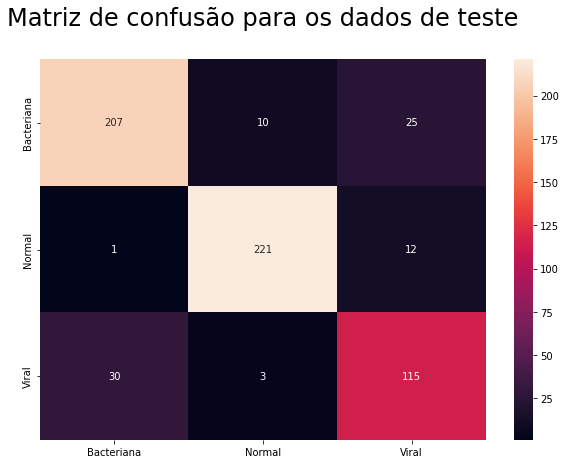

In [ ]:
test_y, pred, test_images = convertData(modelVGG, TEST, 0)

matrix = metrics.confusion_matrix(test_y, pred)

# labels = 
labels = ['Bacteriana' , 'Normal', 'Viral']

df_cm = pd.DataFrame(matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])

df_cm.index = labels
df_cm.columns = labels

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_title("Matriz de confusão para os dados de teste\n", size = 24)
ax

0: Bacterial

1: Normal

2: Viral

In [ ]:
normalLength = len(os.listdir(TEST + '/' + 'NORMAL'))
bacterialLength = len(os.listdir(TEST + '/' + 'BACTERIAL'))
viralLength = len(os.listdir(TEST + '/' + 'VIRAL'))
dataLength = normalLength + bacterialLength +  viralLength

print('Qtd dados de treino: ', dataLength)
print('Qtd dados de pulmão saudavel para treino: ', normalLength)
print('Qtd dados Bacterial', bacterialLength)
print('Qtd dados Viral', viralLength)

Qtd dados de treino:  624
Qtd dados de pulmão saudavel para treino:  234
Qtd dados Bacterial 242
Qtd dados Viral 148


In [ ]:
f1 = f1_score(test_y, pred, average= None)
recall = recall_score(test_y, pred, average= None)
precision = precision_score(test_y, pred, average= None)

metricas = pd.DataFrame([recall, precision, f1], columns=['Bacteriana' , 'Normal', 'Viral'], index = ['Recall', 'Precision','F1-Score']).T
metricas

,Recall,Precision,F1-Score
Bacteriana,0.855,0.870,0.863
Normal,0.944,0.944,0.944
Viral,0.777,0.757,0.767


In [ ]:
testBin = test_y
predBin = pred

i = 0
while i < len(pred):
    if predBin[i] == 0:
        predBin[i] = 3
    elif predBin[i] == 2:
        predBin[i] = 3

    i += 1

k = 0
while k < len(test_y):
    if testBin[k] == 0:
        testBin[k] = 3
    elif testBin[k] == 2:
        testBin[k] = 3

    k += 1

In [ ]:
matrix = metrics.confusion_matrix(testBin, predBin)
matrix

array([[221,  13],
       [ 13, 377]])

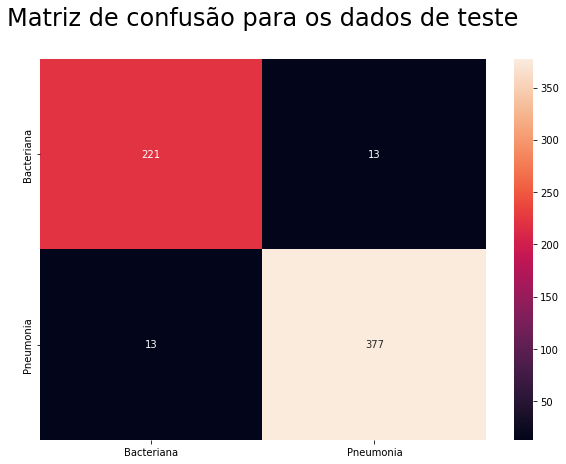

In [ ]:
matrix = metrics.confusion_matrix(testBin, predBin)

# labels = 
labels = ['Normal' , 'Pneumonia']

df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])

df_cm.index = labels
df_cm.columns = labels

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_title("Matriz de confusão para os dados de teste\n", size = 24)
ax

In [ ]:
f1 = f1_score(testBin, predBin, average= None)
recall = recall_score(testBin, predBin, average= None)
precision = precision_score(testBin, predBin, average= None)
acc = accuracy_score(testBin, predBin)

print('ACC:', acc)

metricas = pd.DataFrame([recall, precision, f1], columns=['Normal' , 'Pneumonia'], index = ['Recall', 'Precision','F1-Score']).T
metricas



ACC: 0.9583333333333334


,Recall,Precision,F1-Score
Bacteriana,0.944,0.944,0.944
Pneumonia,0.967,0.967,0.967
